In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

In [6]:
root = '/Users/lukasvandenheuvel/Documents/GRAFF Lab/2021_RabiesTracing/TRIO'
animal = 'TRIO2_test'
path_to_exclusion_file = os.path.join(root, animal, 'RegionsToExclude.csv')
path_to_onotlogy_pickle = '../AllenMouseBrainOntology.pk'

In [7]:
#%%
def get_image_names_in_folder(path):
    '''
    Returns a list of all files in the directory
    that have a '.txt' extension in them. It removes '_LEFT' and '_RIGHT' from the names.
    '''
    all_files = os.listdir(path)
    # Filter txt files, and remove the '_regions.txt' extension
    txt_files = [f.replace('_regions.txt', '') for f in all_files if '_regions.txt' in f]
    # Get rid of '_LEFT' and '_RIGHT':
    files = []
    for f in txt_files:
        if '_LEFT' in f:
            files.append(f.replace('_LEFT', ''))
        elif '_RIGHT' in f:
            files.append(f.replace('_RIGHT', ''))
        else:
            files.append(f)
            
    # Remove doubles and sort:
    files = list(dict.fromkeys(files))
    files.sort()
    
    return files

#%%
def remove_hemisphere(data, hemisphere):
    '''
    This function removes all regions specific to
    a certain hemisphere (either 'Left' or 'Right')
    from a dataframe.
    
    Inputs
    ------
    data (pandas dataframe)
    A dataframe with the counting results of a slice.
    
    hemisphere (string)
    Choose 'Left' or 'Right'.
    '''
    
    if not(hemisphere=='Left' or hemisphere=='Right'):
        raise ValueError('Hemisphere should be either "Left" or "Right"!')
    
    curr_regs = data.index.tolist()
    for region in curr_regs:
        if hemisphere in region:
            data = data.drop(region, axis=0)
    
    return data

#%% 
def import_txt_file_as_dataframe(path_to_txt, hemisphere):
    '''
    This function reads a txt file into a pandas dataframe.
    It does some additional processing steps to make the handling
    of the data easier in the next steps. These steps are:
    - Create a class name for the Root region called ROOT.
    - Replace NaN values with 0.
    - Convert the Class column to the index of the dataframe.
    '''
    data = pd.read_table(path_to_txt)
    img_name = data.loc[0,'Image Name']
    
    # There is one region (the full slice) called 'Root', which has the class 'NaN'
    # associated to it. Replace this NaN with the more descriptive class root.
    data['Class'] = data['Class'].fillna('wholeroot')

    # Set the region classes as the column index
    data = data.set_index('Class')
    
    # Now remove the 'wholeroot'. We'll use the seperate hemispheres.
    data = data.drop('wholeroot', axis=0)
    
    # If a hemisphere is specified, remove the other hemisphere from the dataframe
    if (hemisphere == 'Left'):
        data = remove_hemisphere(data, 'Right')
    elif (hemisphere == 'Right'):
        data = remove_hemisphere(data, 'Left')
    
    return data,img_name

#%%
def find_regions_and_classes_in_slice(data):
    '''
    This function reads a dataframe that corresponds to a brain slice,
    and returns a dictionary with the names of the classes appearing
    in the slice as keys, and the full region names as the corresponding value.
    Example: 
    region_dict['ACAd'] = 'Anterior cingulate area, dorsal part' 
    '''
    # Get the number of rows, columns in dataframe
    num_regions, num_measurements = data.shape
    # Initialize region_dict
    region_dict = {}
    # Loop through all regions
    for region_class in data.index.tolist():
        # Put the region class name (abbreviation)
        # as key in the dictionary, and the full region name as corresponding value.
        region_name = data.loc[region_class,'Name']
        region_class = find_region_abbreviation(region_class)
        region_dict[region_class] = region_name
        
    return region_dict

#%%
def find_region_abbreviation(region_class):
    '''
    This function finds the region abbreviation
    by splitting the class value in the table.
    Example: 'Left: AVA' becomes 'AVA'.
    '''
    try: # try to split the class
        region_abb = region_class.split(': ')[1]
    except: # if splitting gives an error, don't split
        region_abb = str(region_class)
        
    return region_abb

In [8]:
#%%
def list_regions_to_exclude(path_to_exclusion_file):
    '''
    Read the csv file containing the regions to exclude for each image,
    and summarize the information in a dictionary.
    The exclusions_file is to be initialized with initExclusionFile
    '''
    exclude_df = pd.read_csv(path_to_exclusion_file, sep=r'[;,]', index_col='Image Name', engine='python')
    exclude_dict = {}

    for img in exclude_df.index:
        
        exclude_dict[img] = []
        to_exclude = exclude_df['Regions to Exclude (Regions may not overlap!)'].loc[img]
        if type(to_exclude) == str: # if there are regions to exclude
            for region in to_exclude.split('/ '):
                
                # If no hemisphere was specified, add both hemispheres:
                if not 'Right' in region and not 'Left' in region:
                    exclude_dict[img].append('Right: '+region)
                    exclude_dict[img].append('Left: '+region)
                # If left or right hemisphere was specified:
                else:
                    exclude_dict[img].append(region)
                
    return exclude_dict
    
#%%
def exclude_regions(df, regs_to_exclude, edges, tree):
    '''
    Take care of regions to be excluded from the analysis.
    If a region is to be excluded, 2 things must happen:
    (1) The cell counts of that region must be subtracted from all
        its parent regions.
    (2) The region must disappear from the data, together with all 
         its daughter regions.
    '''

    # Take care of regions to exclude
    for reg_hemi in regs_to_exclude:
        hemi = reg_hemi.split(': ')[0]
        reg = reg_hemi.split(': ')[1]

        # Step 1: subtract counting results of the regions to be excluded
        # from their parent regions.
        child = reg
        while True:
            parent = edges[child]
            row = hemi+': '+parent
            # Subtract the counting results from the parent region.
            # Use fill_value=0 to prevent "3-NaN=NaN".
            df.loc[row] = df.loc[row].subtract( df.loc[reg_hemi], fill_value=0 )
            if (parent == 'root'):
                break
            child = parent # go one step further in the tree

        # Step 2: Remove the regions that should be excluded
        # together with their daughter regions.
        subregions = list_all_subregions(reg, tree)
        for subreg in subregions:
            row = hemi+': '+subreg
            if row in df.index:
                df = df.drop(row)
            
    return df


#%%
def sum_cell_counts(data):
    '''
    This function takes as input raw data from a csv file (data = a dataframe created with pd.read_csv).
    It converts counts (Num CTB (only), Num CTB: Rabies (only), etc) to number of detected cells ('CTB, RAB', etc).
    To do this it sums the relevant counts.
    '''
    
    # The parameters we are interested in
    param_list = ['area',                             # DAPI area
                  'CTB', 'RAB', 'TVA',                # single positives + double positives + triple positives
                  'CTB_RAB', 'CTB_TVA', 'RAB_TVA',    # double positives + triple positives
                  'CTB_RAB_TVA']                      # triple positives
    
    # Make an empty table with rows = all regions in current slice, columns = param_list
    df = pd.DataFrame(np.nan, index=data.index, columns=param_list)
    
    # Warning: below, you'll notice that columns are summed a bit weirdly.
    # I used df['c'] = df[['a','b']].sum(axis=1, min_count=1) to sum up columns 'a' and 'b'.
    # min_count=1 ensures that the sum of NaN values is NaN (and not 0).

    df['area'] = data['DAPI: DAPI area um^2']
    # single positives + double positives + triple positives
    df['CTB'] = data[['Num CTB', 'Num CTB: Rabies', 'Num CTB: TVA', 'Num CTB: Rabies: TVA']].sum(axis=1, min_count=1)
    df['RAB'] = data[['Num Rabies', 'Num CTB: Rabies', 'Num Rabies: TVA', 'Num CTB: Rabies: TVA']].sum(axis=1, min_count=1)
    df['TVA'] = data[['Num TVA', 'Num CTB: TVA', 'Num Rabies: TVA', 'Num CTB: Rabies: TVA']].sum(axis=1, min_count=1)
    # double positives + triple positives
    df['CTB_RAB'] = data[['Num CTB: Rabies', 'Num CTB: Rabies: TVA']].sum(axis=1, min_count=1)
    df['CTB_TVA'] = data[['Num CTB: TVA', 'Num CTB: Rabies: TVA']].sum(axis=1, min_count=1)
    df['RAB_TVA'] = data[['Num Rabies: TVA', 'Num CTB: Rabies: TVA']].sum(axis=1, min_count=1)
    # triple positives
    df['CTB_RAB_TVA'] = data['Num CTB: Rabies: TVA']  

    # Return only those regions where DAPI was found
    return df[df['area'] > 0]

In [9]:
def load_cell_counts(root, exclude_dict, edges, tree):
    '''
    Function to load cell counts, stored in .csv files in the 'root' directory,
    as Pandas dataframes.
    '''
    
    # Get the image names present in root (e.g. "Image_01.vsi - 10x_01")
    # and the names of all files present in root (e.g. "Image_01.vsi - 10x_01 LEFT_regions.txt")
    img_names = get_image_names_in_folder(root)
    file_names = os.listdir(root)
    
    # Init dicts and lists to store data
    slice_regions = {}   # which regions do we have per slice?
    slice_data = {}      # what are the cell counts per slice?
    df_list = []         # list of all slice dataframes
    
    # Loop through the image names
    for f in img_names:

        # The following variables will be used to find out whether we have seperate files
        # for seperate hemispheres, or just one file containing both hemispheres.
        fname = f + '_regions.txt'
        fname_left = f + '_LEFT' + '_regions.txt'
        fname_right = f + '_RIGHT' + '_regions.txt'
        both_hemi = False
        right_hemi = False
        left_hemi = False
        regs_to_exclude = []

        # Read text file into a Pandas dataframe
        if fname_left in file_names: # if we have img_name LEFT_regions.txt in folder
            left_hemi = True
            path = os.path.join(root, fname_left)
            data_left,img_name_left = import_txt_file_as_dataframe(path, 'Left')
            regs_to_exclude = regs_to_exclude + exclude_dict[fname_left]
        if fname_right in file_names: # if we have img_name RIGHT_regions.txt in folder
            right_hemi = True
            path = os.path.join(root, fname_right)
            data_right,img_name_right = import_txt_file_as_dataframe(path, 'Right')
            regs_to_exclude = regs_to_exclude + exclude_dict[fname_right]
        if fname in file_names:       # if we have img_name_regions.txt (no hemisphere specification)
            both_hemi = True
            path = os.path.join(root, fname)
            data,img_name = import_txt_file_as_dataframe(path, 'Both')
            regs_to_exclude = regs_to_exclude + exclude_dict[fname]

        # Check for safety: we either have ONE file for both hemispheres,
        # or (max 2) file(s) for seperate hemispheres. Else, raise and error.
        if (left_hemi and both_hemi) or (right_hemi and both_hemi):
            raise ValueError('Either LEFT and/or RIGHT, or no hemisphere specification. But not both!')
        if not(left_hemi) and not(right_hemi) and not(both_hemi):
            raise ValueError('Filename not found!')

        # Combine left and right, if they were both present
        if left_hemi and right_hemi:        # if we have both left and right, combine dataframes
            data = pd.concat([data_left, data_right])
        elif left_hemi and not(right_hemi): # if we have only left, data = data_left
            data = data_left
        elif not(left_hemi) and right_hemi: # if we have only right, data = data_right
            data = data_right

        # Find regions in current slice
        region_dict = find_regions_and_classes_in_slice(data)

        # Combine cell counts
        df = sum_cell_counts(data)
        
        # Take care of regions to be excluded
        df = exclude_regions(df, regs_to_exclude, edges, tree)
        
        # Store results in dictionaries / lists
        slice_regions[f] = region_dict
        slice_data[f] = df
        df_list.append(df)
    
    return df_list,slice_regions,slice_data

In [10]:
# Load brain ontology (brain hierarchy) --------------------------------------
with open(path_to_onotlogy_pickle,"rb") as f:
    ontology_dict = pickle.load(f)
edges = ontology_dict['BrainOntologyEdges']
tree = ontology_dict['BrainOntologyTree']
brain_region_dict = ontology_dict['BrainOntologyRegions']

# Initialize a results dataframe. --------------------------------------------

In [11]:
input_path = os.path.join(root, animal, 'results')
exclude_dict = list_regions_to_exclude(path_to_exclusion_file)

In [12]:
df_list,slice_regions,slice_data = load_cell_counts(input_path, exclude_dict, edges, tree)

In [13]:
df_list[0].head()

,area,CTB,RAB,TVA,CTB_RAB,CTB_TVA,RAB_TVA,CTB_RAB_TVA
Class,,,,,,,,
Left: root,10947984.0,235.0,23.0,NaN,NaN,NaN,NaN,NaN
Left: grey,10632404.0,235.0,23.0,NaN,NaN,NaN,NaN,NaN
Left: CH,10632404.0,235.0,23.0,NaN,NaN,NaN,NaN,NaN
Left: CTX,10632404.0,235.0,23.0,NaN,NaN,NaN,NaN,NaN
Left: CTXpl,10632404.0,235.0,23.0,NaN,NaN,NaN,NaN,NaN


Importing slices in TRIO2_11876_Lukas_v2...
Imported 118 slices.



/Users/lukasvandenheuvel/opt/anaconda3/envs/trio/lib/python3.9/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)



! A results_python folder already existed in root. I am overwriting previous results!


Generating plots ...


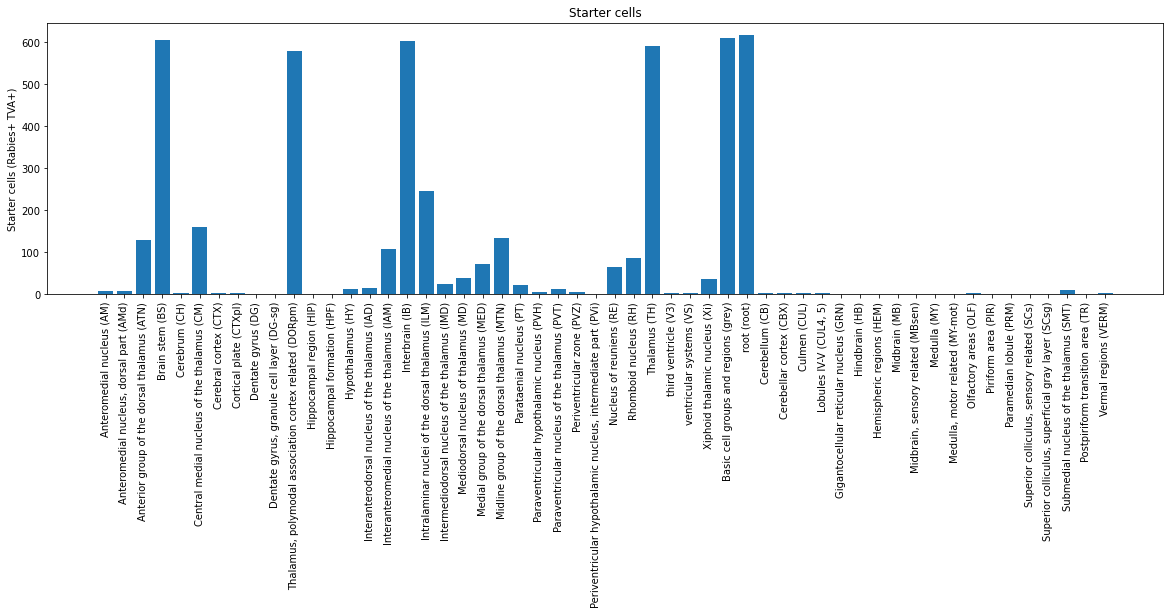

In [14]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

from readCSV_helpers import *

#%% ------------------------------ SET PARAMETERS ----------------------------
# ============================================================================

animal_list = ['TRIO2_11876_Lukas_v2']
root = '/Users/lukasvandenheuvel/Documents/GRAFF Lab/2021_RabiesTracing/TRIO/'
path_to_onotlogy_pickle = '../AllenMouseBrainOntology.pk'

tracers = ['RAB', 'CTB', 'TVA']         # Tracers we are interested in.

#%% -------------------------------- START SCRIPT ----------------------------
# ============================================================================

hemispheres = ['Left', 'Right', 'Sum']  # Store the seperate hemispheres, and the sum of the hemispheres.

# Load brain ontology (brain hierarchy) --------------------------------------
with open(path_to_onotlogy_pickle,"rb") as f:
    ontology_dict = pickle.load(f)
edges = ontology_dict['BrainOntologyEdges']
tree = ontology_dict['BrainOntologyTree']
brain_region_dict = ontology_dict['BrainOntologyRegions']

# Initialize a results dataframe. --------------------------------------------
# This is a dataframe with hierarchical columns. 
# Hierarchy: tracer -> animal -> hemisphere.
iterables = [tracers, animal_list, hemispheres]
multi_index = pd.MultiIndex.from_product(iterables)
results = pd.DataFrame(np.nan, index=brain_region_dict.keys(), columns=multi_index)

#%% Loop over animals, load the data and normalize counts --------------------
for animal in animal_list:

    print('Importing slices in '+animal+'...')
    input_path = os.path.join(root, animal, 'results')

    # Load regions to exclude for this animal
    path_to_exclusion_file = os.path.join(root, animal, 'RegionsToExclude.csv')
    if not(os.path.exists(path_to_exclusion_file)):
        raise ValueError('Cannot find exclusion file for animal ' + animal + '!')
    exclude_dict = list_regions_to_exclude(path_to_exclusion_file)
    
    # Load cell counts, excluding the regions we want to exclude
    df_list,slice_regions,slice_data = load_cell_counts(input_path, exclude_dict, edges, tree)
    print('Imported ' + str(len(df_list)) + ' slices.\n')
    
    # Now comes the tricky part. We'll first concatenate the dataframes
    # of all slices into one big dataframe (brain_df).
    # Then, we combine the rows with the same index (=region name), and sum them.
    # That is, we sum the results (area, cell counts) per region across slices.
    brain_df = pd.concat(df_list)
    brain_df = brain_df.groupby(brain_df.index, axis=0).sum()
    
    # Plot starter cells
    starter_cells = brain_df['RAB_TVA']
    starter_cells = starter_cells[starter_cells > 0]
    starter_cells_sorted = sort_hemispheres(starter_cells)
    
    # Plot starter cells and save brain_df
    index = ['%s (%s)'%(brain_region_dict[key],key) for key in starter_cells_sorted.index]
    plt.figure(figsize=(20,5))
    plt.tight_layout()
    b = plt.bar(index, starter_cells_sorted['Sum'])
    t = plt.xticks(rotation=90)
    t = plt.title('Starter cells')
    lbl = plt.ylabel('Starter cells (Rabies+ TVA+)')
    output_path = os.path.join(root, animal, 'results_python')
    if not(os.path.isdir(output_path)):
        os.mkdir(output_path)
    output_file = os.path.join(output_path, animal+'_starter_cells.pdf')
    plt.savefig(output_file, bbox_inches='tight')
    brain_df.to_csv( os.path.join(output_path, animal+'_cell_counts.csv') )

    # Normalize the results
    for t in tracers: # loop over tracers ('RAB', 'CTB', ...)

        # Normalize
        normalized_cell_counts = normalize_cell_counts(brain_df, t)
        
        # Save results per animal
        present_regions = normalized_cell_counts.index.to_list()
        for region in present_regions: # loop over all regions present
            results.loc[region, (t,animal)].update( normalized_cell_counts.loc[region] )

# Swap hierarchy of columns, to make averaging over animals easier.
# The new hierarchy will be Tracer -> Hemisphere -> Animal
results = results.swaplevel(axis=1)

#%% Calculate means and sems -------------------------------------------------
iterables = [tracers, ['PerHemi', 'SummedHemi'], ['Mean', 'Sem']]
multi_index = pd.MultiIndex.from_product(iterables)
mean_results = pd.DataFrame(np.nan, index=results.index, columns=multi_index)

for t in tracers:
    
    # Normalization per hemisphere: Treat 'Left' and 'Right' as seperate animals to calculate average
    mean_results.loc[:, (t,'PerHemi','Mean')] = results[t][['Left','Right']].mean(axis=1)
    mean_results.loc[:, (t,'PerHemi','Sem')] = results[t][['Left','Right']].sem(axis=1)
    
    # Normalization with summed hemispheres: Sum left and right, and average over animals.
    mean_results.loc[:, (t,'SummedHemi','Mean')] = results[t]['Sum'].mean(axis=1)
    mean_results.loc[:, (t,'SummedHemi','Sem')] = results[t]['Sum'].sem(axis=1)

#%% Save and plot results -----------------------------------------------------
output_path = os.path.join(root, 'results_python')
if not(os.path.exists(output_path)):
    os.mkdir(output_path)
    print('\nCreated a new results_python folder in ' + root + '\n')
else:
    print('\n! A results_python folder already existed in root. I am overwriting previous results!\n')

results.to_csv( os.path.join(output_path, 'results_cell_counts.csv') )
mean_results.to_csv( os.path.join(output_path, 'results_mean_cell_counts.csv') )
print('\nGenerating plots ...')

In [15]:
brain_df

,area,CTB,RAB,TVA,CTB_RAB,CTB_TVA,RAB_TVA,CTB_RAB_TVA
Class,,,,,,,,
Left: AAA,3.332172e+06,252.0,4.0,0.0,0.0,0.0,0.0,0.0
Left: ACA,2.670829e+07,312.0,26.0,0.0,0.0,0.0,0.0,0.0
Left: ACAd,1.565698e+07,272.0,24.0,0.0,0.0,0.0,0.0,0.0
Left: ACAd1,2.400470e+06,56.0,0.0,0.0,0.0,0.0,0.0,0.0
Left: ACAd2/3,3.166327e+06,109.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
Right: vVIIIn,1.406791e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Right: vhc,3.059128e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Right: vtd,2.085964e+05,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [16]:
results

RAB                                            \
                       Left                Right                  Sum   
       TRIO2_11876_Lukas_v2 TRIO2_11876_Lukas_v2 TRIO2_11876_Lukas_v2   
root               1.000000             1.000000             1.000000   
grey               1.046804             1.048726             1.047763   
CH                 0.606952             0.560212             0.582401   
CTX                0.409012             0.457253             0.433682   
CTXpl              0.409451             0.467528             0.439156   
...                     ...                  ...                  ...   
ipf                     NaN                  NaN                  NaN   
pms                     NaN                  NaN                  NaN   
pfs                     NaN                  NaN                  NaN   
IPF                     NaN                  NaN                  NaN   
retina                  NaN                  NaN                  NaN   

                        CTB                                            \
                       Left                Right                  Sum   
       TRIO2_11876_Lukas_v2 TRIO2_11876_Lukas_v2 TRIO2_11876_Lukas_v2   
root               1.000000             1.000000             1.000000   
grey               1.038282             1.087203             1.065268   
CH                 1.524168             1.652456             1.592174   
CTX                1.631312             1.973132             1.815705   
CTXpl              1.328321             1.510665             1.425760   
...                     ...                  ...                  ...   
ipf                     NaN                  NaN                  NaN   
pms                     NaN                  NaN                  NaN   
pfs                     NaN                  NaN                  NaN   
IPF                     NaN                  NaN                  NaN   
retina                  NaN                  NaN                  NaN   

                        TVA                                            
                       Left                Right                  Sum  
       TRIO2_11876_Lukas_v2 TRIO2_11876_Lukas_v2 TRIO2_11876_Lukas_v2  
root               1.000000             1.000000             1.000000  
grey               1.088992             1.085461             1.085899  
CH                 0.037362             0.028352             0.030598  
CTX                0.038134             0.027502             0.030182  
CTXpl              0.025627             0.019080             0.020709  
...                     ...                  ...                  ...  
ipf                     NaN                  NaN                  NaN  
pms                     NaN                  NaN                  NaN  
pfs                     NaN                  NaN                  NaN  
IPF                     NaN                  NaN                  NaN  
retina                  NaN                  NaN                  NaN  

[1327 rows x 9 columns]

In [ ]:
def plot_horizontal_bar_chart(data, brain_region_dict):
    
    # remove all regions without any cells present, and sort by sum.
    data = data[data['Mean'] > 0].sort_values(by=['Mean'])

    mean = data['Mean']
    errorbars = data['Sem']

    font_color = '#525252'
    fontsize = 35
    facecolor = '#eaeaf2'
    color_red = '#fd625e'
    color_blue = '#01b8aa'
    index = ['%s (%s)'%(brain_region_dict[key],key) for key in data.index]
    xerr = None if errorbars is None else errorbars
    max_value  = np.nanmax(mean.to_numpy()) + np.nanmax(errorbars.to_numpy())

    # Generate figure
    fig = plt.figure(figsize=(50,120), facecolor=facecolor)
    fig.tight_layout()

    # Plot bars and vertical line at x=1
    plt.barh(index, mean, align='center', color=color_red, zorder=10, xerr=xerr)
    plt.axvline(x=1, c='k', linestyle='--')
    plt.xlim([0, 1.2 * max_value])
    
    return fig

In [35]:
mean_results.head(5)

RAB                                CTB                           \
        PerHemi           SummedHemi       PerHemi           SummedHemi       
           Mean       Sem       Mean Sem      Mean       Sem       Mean Sem   
root   1.000000  0.000000   1.000000 NaN  1.000000  0.000000   1.000000 NaN   
grey   1.047765  0.000961   1.047763 NaN  1.062742  0.024461   1.065268 NaN   
CH     0.583582  0.023370   0.582401 NaN  1.588312  0.064144   1.592174 NaN   
CTX    0.433133  0.024120   0.433682 NaN  1.802222  0.170910   1.815705 NaN   
CTXpl  0.438489  0.029038   0.439156 NaN  1.419493  0.091172   1.425760 NaN   

            TVA                           
        PerHemi           SummedHemi      
           Mean       Sem       Mean Sem  
root   1.000000  0.000000   1.000000 NaN  
grey   1.087227  0.001766   1.085899 NaN  
CH     0.032857  0.004505   0.030598 NaN  
CTX    0.032818  0.005316   0.030182 NaN  
CTXpl  0.022354  0.003274   0.020709 NaN

In [37]:
import plotly.express as px

data = mean_results.RAB.PerHemi
data = data[data['Mean'] > 0].sort_values(by=['Mean'])
fig = px.bar(data, 
             x='Mean', 
             error_x='Sem', 
             orientation='h',
             width=800, height=2000
            )
fig.show()